In [1]:
import glob
import re

import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import scienceplots
import scipy.fftpack as fftpack
import statsmodels as sm
import statsmodels.nonparametric
from scipy import stats
from scipy.signal import savgol_filter
from statsmodels.nonparametric.kernel_regression import KernelReg

plt.style.use("science")

In [2]:
def smooth_data_convolve_my_average(arr, span):
    re = np.convolve(arr, np.ones(span * 2 + 1) / (span * 2 + 1), mode="same")

    re[0] = np.average(arr[:span])
    for i in range(1, span + 1):
        re[i] = np.average(arr[: i + span])
        re[-i] = np.average(arr[-i - span :])
    return re


def smooth_data_np_average(arr, span):  # my original, naive approach
    return np.array(
        [np.average(arr[val - span : val + span + 1]) for val in range(len(arr))]
    )


def smooth_data_np_convolve(arr, span):
    return np.convolve(arr, np.ones(span * 2 + 1) / (span * 2 + 1), mode="same")


def smooth_data_np_cumsum_my_average(arr, span):
    cumsum_vec = np.cumsum(arr)
    moving_average = (cumsum_vec[2 * span :] - cumsum_vec[: -2 * span]) / (2 * span)

    # The "my_average" part again. Slightly different to before, because the
    # moving average from cumsum is shorter than the input and needs to be padded
    front, back = [np.average(arr[:span])], []
    for i in range(1, span):
        front.append(np.average(arr[: i + span]))
        back.insert(0, np.average(arr[-i - span :]))
    back.insert(0, np.average(arr[-2 * span :]))
    return np.concatenate((front, moving_average, back))


def smooth_data_lowess(arr, span):
    x = np.linspace(0, 1, len(arr))
    return sm.nonparametric.lowess(
        arr, x, frac=(5 * span / len(arr)), return_sorted=False
    )


def smooth_data_kernel_regression(arr, span):
    kr = KernelReg(arr, np.linspace(0, 1, len(arr)), "c")
    return kr.fit()[0]


def smooth_data_savgol_0(arr, span):
    return savgol_filter(arr, span * 2 + 1, 0)


def smooth_data_savgol_1(arr, span):
    return savgol_filter(arr, span * 2 + 1, 1)


def smooth_data_savgol_2(arr, span):
    return savgol_filter(arr, span * 2 + 1, 2)


def is_good(loss):
    # return loss not in ('1e+100', '100.0')
    return float(loss) < 100


def load_file(alg, problem, kappa):
    mapping = {"bayesian": "bo", "ga": "ga", "random": "random"}
    options = (problem, alg, mapping[alg], kappa)
    files = glob.glob("%s/%s/%s-%s-run-*" % options)
    LOSSES = []
    TIMES = []
    m = float("inf")
    for File in files:
        losses = []
        times = []
        with open(File, "r") as file:
            for line in file:
                loss, ttime = re.findall(r"\[.*\] (.*) (.*)", line.strip())[0]
                times.append(float(ttime))
                if is_good(loss):
                    losses.append(float(loss))
                else:
                    losses.append(np.inf)

        m = min(m, len(losses))
        LOSSES.append(losses)
        TIMES.append(times)

    losses = [loss[:m] for loss in LOSSES]
    losses = np.array(losses)
    times = np.array([time[:m] for time in TIMES])
    return times[:, :MAX_FUNC_CALLS], losses[:, :MAX_FUNC_CALLS]


def plot_accuracy(data, ax, label, color, smooth_func=smooth_data_np_average):
    mean_values = smooth_func(np.mean(data, axis=0), SMOOTH_SIZE)
    sem = stats.sem(data, axis=0)

    # Calculate the 95% confidence interval
    conf_int = smooth_func(
        sem * stats.t.ppf((1 + 0.95) / 2.0, data.shape[0] - 1), SMOOTH_SIZE
    )

    ax.plot((mean_values), label=label, color=color)
    ax.fill_between(
        range(len(mean_values)),
        mean_values - conf_int,
        mean_values + conf_int,
        alpha=0.3,
        color=color,
    )


def get_failures(runs, bin_size):
    failures = []
    for run in runs:
        data = run.tolist()
        bins = [data[i : i + bin_size] for i in range(0, len(data), bin_size)]
        counts = [bin.count(float("inf")) for bin in bins]
        failures.append(counts)
    return np.array(failures).mean(0)

In [3]:
kappa = "0.5"
problems = ["volterra-population", "kidder"]
algorithms = ["random", "bayesian", "ga"]
LABELS = ["Random Search", "Bayesian Optimization", "Genetic Algorithm"]
colors = ["tab:green", "tab:orange", "tab:blue"]
problem = problems[1]
MAX_FUNC_CALLS = 292
SMOOTH_SIZE = 3

In [4]:
VOLTERRA_LOSS = []
VOLTERRA_TIME = []
KIDDER_LOSS = []
KIDDER_TIME = []

problem = problems[0]
for algorithm in algorithms:
    time, loss = load_file(algorithm, problem, kappa)
    VOLTERRA_LOSS.append(loss)
    VOLTERRA_TIME.append(time)

problem = problems[1]
for algorithm in algorithms:
    time, loss = load_file(algorithm, problem, kappa)
    KIDDER_LOSS.append(loss)
    KIDDER_TIME.append(time)


np.array(VOLTERRA_LOSS).shape, np.array(VOLTERRA_TIME).shape, np.array(
    KIDDER_LOSS
).shape, np.array(KIDDER_TIME).shape,

((3, 10, 292), (3, 10, 292), (3, 10, 292), (3, 10, 292))

# Accuracy

/home/conficker/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/conficker/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/conficker/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


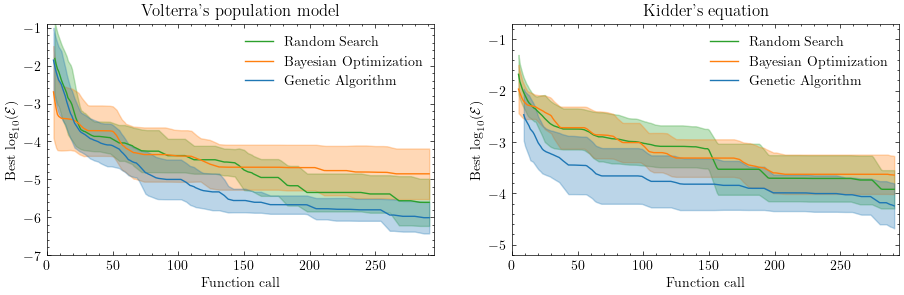

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(11, 3))

for i in range(3):
    loss = np.log10(np.minimum.accumulate(VOLTERRA_LOSS[i].T).T)
    plot_accuracy(loss, axs[0], label=LABELS[i], color=colors[i])

for i in range(3):
    loss = np.log10(np.minimum.accumulate(KIDDER_LOSS[i].T).T)
    plot_accuracy(loss, axs[1], label=LABELS[i], color=colors[i])

axs[0].legend()
axs[1].legend()

axs[0].set_title("Volterra's population model")
axs[1].set_title("Kidder's equation")

axs[0].set_xlabel("Function call")
axs[1].set_xlabel("Function call")

axs[0].set_ylabel(r"Best $\log_{10}(\mathcal{E})$")
axs[1].set_ylabel(r"Best $\log_{10}(\mathcal{E})$")


axs[0].set_ylim(-7, -0.9)
axs[1].set_ylim(-5.2, -0.7)

axs[0].set_xlim(0, 295)
axs[1].set_xlim(0, 295)
fig.savefig("time-kidder-volterra-accuracy.pdf", bbox_inches="tight")

# Time

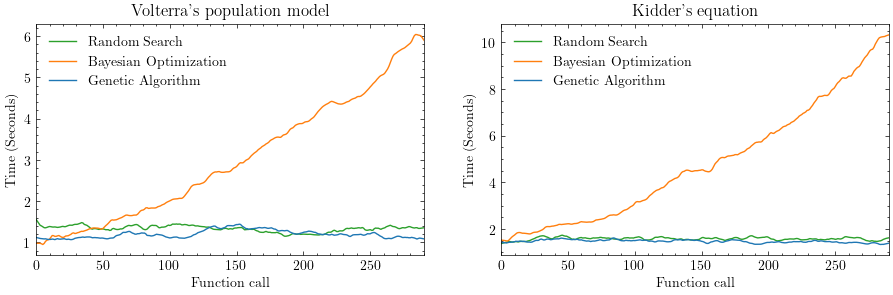

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(11, 3))

for i in range(3):
    time = np.gradient(VOLTERRA_TIME[i], axis=1).mean(axis=0)
    time = smooth_data_savgol_1(time, 3)
    axs[0].plot(time, label=LABELS[i], color=colors[i])

for i in range(3):
    time = np.gradient(KIDDER_TIME[i], axis=1).mean(axis=0)
    time = smooth_data_savgol_1(time, 3)
    axs[1].plot(time, label=LABELS[i], color=colors[i])

axs[0].legend()
axs[1].legend()

axs[0].set_title("Volterra's population model")
axs[1].set_title("Kidder's equation")

axs[0].set_xlabel("Function call")
axs[1].set_xlabel("Function call")

axs[0].set_ylabel("Time (Seconds)")
axs[1].set_ylabel("Time (Seconds)")

axs[0].set_xlim(0, 290)
axs[1].set_xlim(0, 290)


fig.savefig("time-kidder-volterra.pdf", bbox_inches="tight")

# Failures

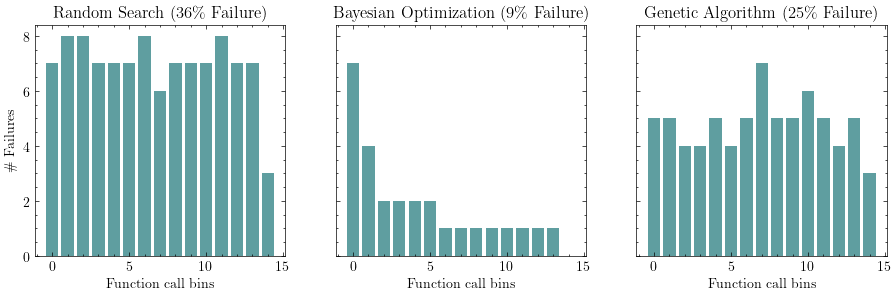

In [7]:
fig, axs = plt.subplots(1, 3, figsize=(11, 3), sharey=True)
color = mcolors.CSS4_COLORS["cadetblue"]

bin_size = 20

for i in range(3):
    bins = np.round(get_failures(VOLTERRA_LOSS[i], bin_size=bin_size))
    axs[i].bar(
        np.arange(len(bins)),
        bins,
        color=color,
    )
    axs[i].set_title(
        LABELS[i]
        + " (%.0f" % (100 * sum(bins) / len(VOLTERRA_LOSS[i][0]))
        + "\% Failure)"
    )

axs[0].set_xlabel("Function call bins")
axs[1].set_xlabel("Function call bins")
axs[2].set_xlabel("Function call bins")

axs[0].set_ylabel("\# Failures")

fig.savefig("failures-ga-bo-volterra-population.pdf", bbox_inches="tight")

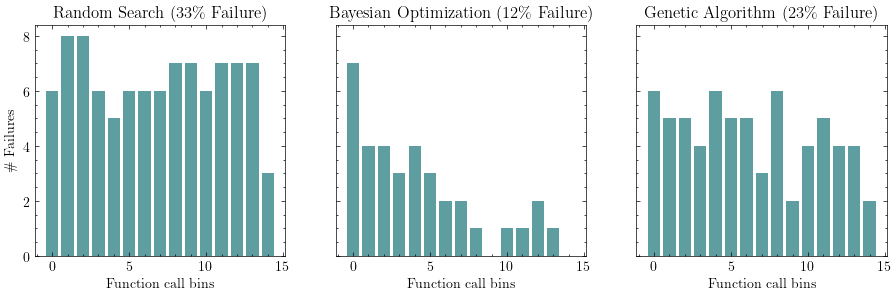

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(11, 3), sharey=True)

for i in range(3):
    bins = np.round(get_failures(KIDDER_LOSS[i], bin_size=bin_size))
    axs[i].bar(
        np.arange(len(bins)),
        bins,
        color=color,
    )
    axs[i].set_title(
        LABELS[i]
        + " (%.0f" % (100 * sum(bins) / len(KIDDER_LOSS[i][0]))
        + "\% Failure)"
    )

axs[0].set_xlabel("Function call bins")
axs[1].set_xlabel("Function call bins")
axs[2].set_xlabel("Function call bins")

axs[0].set_ylabel("\# Failures")

fig.savefig("failures-ga-bo-kidder.pdf", bbox_inches="tight")